Let's discover relations between natures and each agency.

In [18]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from random import randint 
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

# Load data
Clean it and save the cleaned version.

In [6]:
# calls = pd.read_csv('../data/callsforservicefiltered.csv')
# calls = calls[calls.rptonly != True]
# calls = calls[calls.cancelled != True]
# calls = calls[calls.nature != 'TRANSPORT TO ANIMAL SHELTER']
# calls['calltime'] = pd.to_datetime(calls.calltime)
# calls['year'] = calls.calltime.apply(lambda x: x.date().year)
# calls['month'] = calls.calltime.apply(lambda x: x.date().month)
# calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
# calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
# calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
# calls = calls.drop(columns = ['timeclose', 'calltime'], axis = 1)
# calls = calls.drop(columns = ['statbeat','ra'])
# calls['actualnature'] = [x['nature2'] if x['nature'] is np.nan and x['nature']!=x['nature2']
#                         else x['nature'] for i,x in calls.iterrows()]
# calls = calls.drop(columns = ['nature','nature2'])
# calls = calls.rename(columns={'actualnature' : 'nature'})

# calls.to_csv('../data/cleaned_callsforservicefiltered.csv', sep='\t', index=False)

/home/oana/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's split the data into 4 data sets based on the 4 agencies.

In [43]:
filtered_calls = pd.read_csv('../data/cleaned_callsforservicefiltered.csv', sep='\t')

## Predict time needed for crew to stabilise the person since the moment of arrival to the moment of transport

## Data Preping
First, let's see the correlation between all the features. Since we will use linear regression to predict the time, we have to eliminate correlated variables in order to improve the skill of the model.

In [44]:
def string_to_numbers(input, column_name):
        
    mapped_list = []
    mapping = dict()    
    for x in input[column_name].unique():
        mapping[x] = randint(1, 1000000)        
    for i in input.index:
        mapped_list.append(mapping[input.at[i, column_name]])
    return mapped_list

In [45]:
filtered_calls['callsource_no'] = string_to_numbers(filtered_calls, 'callsource')
filtered_calls['city_no'] = string_to_numbers(filtered_calls, 'city')
filtered_calls['service_no'] = string_to_numbers(filtered_calls, 'service')
filtered_calls['agency_no'] = string_to_numbers(filtered_calls, 'agency')
filtered_calls['district_no'] = string_to_numbers(filtered_calls, 'district')
filtered_calls['gp_no'] = string_to_numbers(filtered_calls, 'gp')
filtered_calls['primeunit_no'] = string_to_numbers(filtered_calls, 'primeunit')
filtered_calls['firstdisp_no'] = string_to_numbers(filtered_calls, 'firstdisp')
filtered_calls['nature_no'] = string_to_numbers(filtered_calls, 'nature')
filtered_calls.replace({'priority': 'P'}, value=10, inplace=True)
filtered_calls.dropna(inplace=True)
filtered_calls.drop(columns=['year'], inplace=True)

## Log Transformation
Let's bring all the numerical value into the same range by logarithmizing those values.

In [46]:
print(filtered_calls.columns)
filtered_calls.secs2rt = filtered_calls.secs2rt.apply(np.log)
filtered_calls.secs2di = filtered_calls.secs2di.apply(np.log)
filtered_calls.secs2en = filtered_calls.secs2en.apply(np.log)
filtered_calls.secs2ar = filtered_calls.secs2ar.apply(np.log)
filtered_calls.secs2tr = filtered_calls.secs2tr.apply(np.log)
filtered_calls.secs2lc = filtered_calls.secs2lc.apply(np.log)
filtered_calls.secsdi2en = filtered_calls.secsdi2en.apply(np.log)
filtered_calls.secsdi2ar = filtered_calls.secsdi2ar.apply(np.log)
filtered_calls.secsar2tr = filtered_calls.secsar2tr.apply(np.log)
filtered_calls.secsar2lc = filtered_calls.secsar2lc.apply(np.log)
filtered_calls.secsrt2dsp = filtered_calls.secsrt2dsp.apply(np.log)
filtered_calls.secstr2lc = filtered_calls.secstr2lc.apply(np.log)

Index(['callsource', 'city', 'priority', 'rptonly', 'service', 'agency',
       'district', 'gp', 'primeunit', 'cancelled', 'closecode', 'dayOfWeek',
       'secs2rt', 'secs2di', 'secs2en', 'secs2ar', 'secs2tr', 'secs2lc',
       'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc', 'secsrt2dsp',
       'secstr2lc', 'firstdisp', 'month', 'dayOfMonth', 'hour', 'nature',
       'callsource_no', 'city_no', 'service_no', 'agency_no', 'district_no',
       'gp_no', 'primeunit_no', 'firstdisp_no', 'nature_no'],
      dtype='object')


Apparently during log transf, we got some values that are set to infinity when input to log is 0. Substitute those values with 0.

In [47]:
filtered_calls.replace([np.inf, -np.inf], 0, inplace=True)
print(len(filtered_calls))

982896


In [24]:
copy_data = filtered_calls.copy(deep=True)
copy_data = copy_data.drop(columns=['callsource', 'city', 'service', 'agency', 'district', 
                    'gp', 'primeunit', 'firstdisp', 'nature'])
#eliminate data that is non related or cannot be known for our prediction
copy_data = copy_data.drop(columns=['secs2lc', 'secsar2lc', 
                                    'secstr2lc', 'cancelled', 'rptonly', 'closecode'])
copy_data.corr()

,dayOfWeek,secs2rt,secs2di,secs2en,secs2ar,secs2tr,secsdi2en,secsdi2ar,secsar2tr,secsrt2dsp,...,hour,callsource_no,city_no,service_no,agency_no,district_no,gp_no,primeunit_no,firstdisp_no,nature_no
dayOfWeek,1.000000,-0.022174,-0.019123,-0.021256,-0.031440,-0.016080,-0.030013,-0.034255,-0.016963,-0.012596,...,0.007878,0.000169,-0.001213,0.021637,0.005367,-0.006050,-0.002966,0.006795,0.011135,-0.026042
secs2rt,-0.022174,1.000000,0.831739,0.686076,0.617688,0.364503,0.425523,0.566538,0.361007,0.678129,...,0.075426,-0.047073,0.043227,-0.447829,0.257163,-0.042600,0.056387,0.004889,0.020142,0.069001
secs2di,-0.019123,0.831739,1.000000,0.882132,0.777873,0.402144,0.568362,0.709486,0.391566,0.955390,...,0.103633,-0.002071,0.056848,-0.550589,0.077411,-0.025463,0.066535,0.017731,0.020045,0.115653
secs2en,-0.021256,0.686076,0.882132,1.000000,0.770662,0.396102,0.785153,0.756139,0.388878,0.857922,...,0.088526,-0.001698,0.049373,-0.539725,-0.080272,0.014525,0.063267,0.015028,0.014232,0.107323
secs2ar,-0.031440,0.617688,0.777873,0.770662,1.000000,0.414445,0.603584,0.974437,0.410633,0.742509,...,0.076430,0.002223,0.046222,-0.522645,-0.060257,0.047294,0.053653,-0.000502,0.013059,0.140229
secs2tr,-0.016080,0.364503,0.402144,0.396102,0.414445,1.000000,0.263150,0.405639,0.998761,0.394182,...,0.002510,0.031507,-0.029748,-0.662253,0.241442,0.096237,0.052205,0.034906,0.077104,0.012510
secsdi2en,-0.030013,0.425523,0.568362,0.785153,0.603584,0.263150,1.000000,0.637428,0.268322,0.530933,...,0.040974,-0.004744,0.048300,-0.415278,-0.268946,0.054255,0.047886,-0.008271,-0.000682,0.085628
secsdi2ar,-0.034255,0.566538,0.709486,0.756139,0.974437,0.405639,0.637428,1.000000,0.406508,0.673674,...,0.067986,0.000791,0.041599,-0.528421,-0.073717,0.066845,0.056193,-0.008378,0.014124,0.132852
secsar2tr,-0.016963,0.361007,0.391566,0.388878,0.410633,0.998761,0.268322,0.406508,1.000000,0.380555,...,0.001023,0.031198,-0.029954,-0.661873,0.241517,0.098405,0.052425,0.032599,0.076747,0.012119
secsrt2dsp,-0.012596,0.678129,0.955390,0.857922,0.742509,0.394182,0.530933,0.673674,0.380555,1.000000,...,0.106257,0.017107,0.051769,-0.539792,0.029785,-0.014852,0.064811,0.023240,0.020399,0.100926


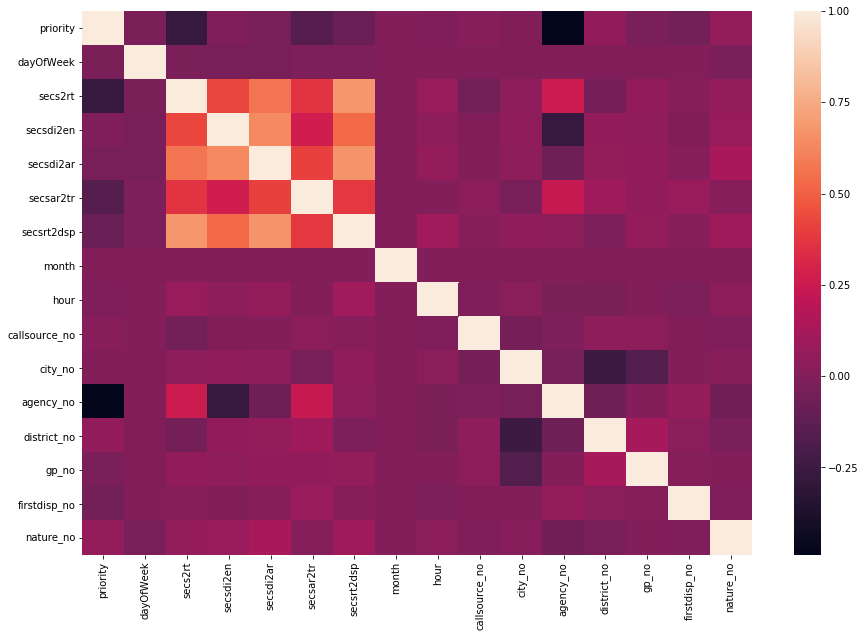

In [61]:
import seaborn as sns
corr = copy_data.corr()
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)

We can see strong correlations between primeunit and firstdisp, service_no and agency_no,
secs2di and secs2rt, seces2en and secs2rt, secs2ar and secs2rt, secs2en -secs2di, secs2ar-secs2di, secsrt2dsp-secs2di, secsdi2ar-secs2ar, secsrt2dsp-secs2ar, secs2tr-secsar2tr, secs2en-secsrt2dsp. 
We will eliminate secs2di, secs2en, secs2ar, primeunit_no, service_no.
Also, since we are trying to predict secs needed from arrival to transport, we have to eliminate secs2tr, which includes secsar2tr.
//Also, since both city_no and district_no influence secsar2tr, we will wliminate district_no.
Also, we have a duplicate feature: day of month and day of week. We will keep the more exact one, day of week and eliminate the other one.

In [26]:
copy_data.drop(columns=['primeunit_no', 'service_no',
                        'secs2en', 'secs2di', 'secs2ar', 'dayOfMonth', 'secs2tr'], inplace=True)
copy_data.priority = copy_data.priority.astype(str).astype(int)
copy_data.corr()

,priority,dayOfWeek,secs2rt,secsdi2en,secsdi2ar,secsar2tr,secsrt2dsp,month,hour,callsource_no,city_no,agency_no,district_no,gp_no,firstdisp_no,nature_no
priority,1.000000,-0.023496,-0.272219,-0.007083,-0.032504,-0.155107,-0.085417,-0.000356,-0.008738,0.017830,-0.001890,-0.488989,0.055679,-0.028204,-0.048308,0.065115
dayOfWeek,-0.023496,1.000000,-0.022174,-0.030013,-0.034255,-0.016963,-0.012596,-0.002939,0.007878,0.000169,-0.001213,0.005367,-0.006050,-0.002966,0.011135,-0.026042
secs2rt,-0.272219,-0.022174,1.000000,0.425523,0.566538,0.361007,0.678129,0.004359,0.075426,-0.047073,0.043227,0.257163,-0.042600,0.056387,0.020142,0.069001
secsdi2en,-0.007083,-0.030013,0.425523,1.000000,0.637428,0.268322,0.530933,0.003561,0.040974,-0.004744,0.048300,-0.268946,0.054255,0.047886,-0.000682,0.085628
secsdi2ar,-0.032504,-0.034255,0.566538,0.637428,1.000000,0.406508,0.673674,-0.000364,0.067986,0.000791,0.041599,-0.073717,0.066845,0.056193,0.014124,0.132852
secsar2tr,-0.155107,-0.016963,0.361007,0.268322,0.406508,1.000000,0.380555,-0.003492,0.001023,0.031198,-0.029954,0.241517,0.098405,0.052425,0.076747,0.012119
secsrt2dsp,-0.085417,-0.012596,0.678129,0.530933,0.673674,0.380555,1.000000,0.001258,0.106257,0.017107,0.051769,0.029785,-0.014852,0.064811,0.020399,0.100926
month,-0.000356,-0.002939,0.004359,0.003561,-0.000364,-0.003492,0.001258,1.000000,0.004520,0.000705,-0.003082,0.003968,-0.001143,0.000983,-0.002789,0.001048
hour,-0.008738,0.007878,0.075426,0.040974,0.067986,0.001023,0.106257,0.004520,1.000000,-0.009008,0.027542,-0.018867,-0.018012,0.000019,-0.017523,0.033406
callsource_no,0.017830,0.000169,-0.047073,-0.004744,0.000791,0.031198,0.017107,0.000705,-0.009008,1.000000,-0.045341,-0.014540,0.045779,0.031040,-0.005692,-0.010963


Let's try first a linear regression using nature as the independent variable.

In [27]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# input = copy_data[['nature_no', 'secsar2tr', 'secsdi2ar', 'firstdisp_no']].copy()
# results = smf.ols(formula='secsar2tr ~ nature_no + secsdi2ar + firstdisp_no', data=input).fit()
# print(results.params)
# print('R squared '+str(results.rsquared))
# print(results.summary())
targets = copy_data.secsar2tr
targets[:, np.newaxis]
# features = copy_data[['nature_no', 'secsdi2ar', 'firstdisp_no', 'city_no']]
features = copy_data.drop(columns=['secsar2tr'])
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, 
                                                    random_state=123, shuffle=True)
# X_train = X_train[:, np.newaxis]
# y_train = y_train[:, np.newaxis]
# X_test = X_test[:, np.newaxis]
# y_test = y_test[:, np.newaxis]

model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_)
predicted_values = model.predict(X_test)
print('R squared of the model on testing data '+str(model.score(X_test, y_test)))
print('root mean square error of the model '+str(mean_squared_error(y_test, predicted_values)))

[ 8.24753104e-03 -7.08414074e-03  2.15119138e-02  1.95050122e-01
  3.22819811e-01  2.64808414e-01 -5.18787962e-03 -1.51922823e-02
  4.99503789e-07 -2.96151500e-07  5.37616417e-06  9.93406058e-07
  5.85222592e-08  6.06472402e-07 -2.94510596e-07]
R squared of the model on testing data 0.27275840665405715
root mean square error of the model 8.890231022287521


Let's try a simple Random Forest Regressor to see what we get.

In [33]:
targets = copy_data.secsar2tr
targets[:, np.newaxis]
features = copy_data.drop(columns=['secsar2tr'])
print(features.columns)
kfold = model_selection.KFold(n_splits=10, shuffle = True, random_state=7)
model = RandomForestRegressor(random_state=123, n_jobs=-1)
results_cv = model_selection.cross_val_score(model, features, targets, cv=kfold,
                                                     scoring='r2')         
print('Mean r squared is '+str(results_cv.mean()))

Index(['priority', 'dayOfWeek', 'secs2rt', 'secsdi2en', 'secsdi2ar',
       'secsrt2dsp', 'month', 'hour', 'callsource_no', 'city_no', 'agency_no',
       'district_no', 'gp_no', 'firstdisp_no', 'nature_no'],
      dtype='object')


/home/oana/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/oana/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/oana/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/oana/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

Mean r squared is 0.5018014803456674


Let's try to play with the parameters to tune the model. Also we will use k fold validation to evaluate our model.
Since we have a total of 16 features, the max no of features that a node has to choose from in regression cases is features/3, with a min of 5.
Value k for k fold validation will be 10, as it was proven to work based on the articles read.
We will try to use different numbers of trees in the forest.

In [39]:
targets = copy_data.secsar2tr
targets[:, np.newaxis]
features = copy_data.drop(columns=['secsar2tr'])
n_trees = [1, 10, 25, 50, 100]
n_features = [5, 7]
for trees in n_trees:
    for no_features in n_features:
        kfold = model_selection.KFold(n_splits=10, shuffle = True, random_state=7)
        model = RandomForestRegressor(n_estimators=trees, max_features=no_features,
                                          random_state=123, n_jobs=-1)
        results_cv = model_selection.cross_val_score(model, features, targets, cv=kfold,
                                                     scoring='r2')         
        print('For model n_trees '+str(trees)+', max features '+str(no_features)+\
              ', Mean r squared is '+str(results_cv.mean()))

For model n_trees 1, max features 5, Mean r squared is 0.09850048327883393
For model n_trees 1, max features 7, Mean r squared is 0.10392565431046075
For model n_trees 10, max features 5, Mean r squared is 0.507611549947459
For model n_trees 10, max features 7, Mean r squared is 0.5072429650831507
For model n_trees 25, max features 5, Mean r squared is 0.5342475577445236
For model n_trees 25, max features 7, Mean r squared is 0.533894667118948
For model n_trees 50, max features 5, Mean r squared is 0.5434994468760344
For model n_trees 50, max features 7, Mean r squared is 0.543147259733164
For model n_trees 100, max features 5, Mean r squared is 0.5479702627427181
For model n_trees 100, max features 7, Mean r squared is 0.5475937690285944


Let's see validation curves also and plot them.

In [57]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

targets = copy_data.secsar2tr
targets[:, np.newaxis]
features = copy_data.drop(columns=['secsar2tr'])
no_trees = [1, 10, 25, 50, 100]
model_test = RandomForestRegressor(random_state=123, n_jobs=-1)
val_train, val_test = validation_curve(model_test, features, targets,
                                       'n_estimators', no_trees, cv=10,
                                       scoring=rms_error, n_jobs=-1)

Exception in thread Thread-4495:
Traceback (most recent call last):
  File "/home/oana/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/oana/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/oana/anaconda3/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/oana/anaconda3/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/oana/anaconda3/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/oana/anaconda3/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/oana/anaconda3/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/oana/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
 

AttributeError: 'NoneType' object has no attribute 'terminate'

In [ ]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plt.figure(figsize=(10,8))
plot_with_err(no_trees, val_train, label='training scores')
plot_with_err(no_trees, val_test, label='validation scores')
plt.xlabel('trees'); plt.ylabel('rms error')
plt.legend();